<a href="https://colab.research.google.com/github/HasanF19/YZM308_FINAL_PROJECT/blob/main/YZM308_Last_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hasan ***Atakan*** Öztürk 220212002

Üretken Yapay Zeka YZM308 Final Projesi Türkçe şarkı sözü Üretimi


#Proje Temeli GenAi kısmı

##1)Kurulum ve import

In [142]:
!pip install --quiet sentencepiece tensorflow pandas openpyxl


In [143]:
import pandas as pd, sentencepiece as spm, tensorflow as tf, numpy as np, os, io, textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Sequential
from IPython.display import Image as ColabImage, display
from PIL import Image, ImageDraw, ImageFont

##2)Dataset Tanıtım

In [144]:
#Öncelikle sizlere datasetimi tanıtmak istiyorum csv formatındaki bu dosyanın düzenlenmiş hali kullanılmaktadır
# *yüklüyoruz*
data = pd.read_csv("/content/drive/MyDrive/Python/CsvData.csv")
data.head()

,sarkici,sarkisi,album,sozler
0,Ahmet Kaya,"(Potbori) Fabrika Kızı, Cama Çıkma, Fabrika Önü",Şafak Türküsü,Bir mavi otobüs gelirdi\nSeni alır giderdi\nO ...
1,Ahmet Kaya,Acı Ninni,Baş Kaldırıyorum,"Uyusun ha iyi büyüsün,\nCamlar buğulanmasın\nS..."
2,Ahmet Kaya,Acılara Tutunmak,Acılara Tutunmak,Kavuşmak özgürlükse özgürdük ikimiz de\nElleri...
3,Ahmet Kaya,Ada Sahilleri,Hoşçakalın Gözüm,Ada sahillerinde bekliyorum\nHer zaman yolları...
4,Ahmet Kaya,Adı Bahtiyar,Dinle Sevgili Ülkem,"Geçiyor önümden, sirenler içinde\nAh eller üst..."


In [145]:
print("Şarkıcı listesi---->Şarkı sayısı:\n",data.sarkici.value_counts())
print("Dataset boyutu:",data.shape)

Şarkıcı listesi---->Şarkı sayısı:
 sarkici
Zeki Müren                 500
Müslüm Gürses              432
Sezen Aksu                 357
Sagopa Kajmer              321
Orhan Gencebay             295
Serdar Ortaç               243
Ahmet Kaya                 224
Ceza                       211
Barış Manço                157
Sertab Erener              156
Zülfü Livaneli             148
Cem Adrian                 140
Tarkan                     138
Candan Erçetin             137
Cem Karaca                 136
Kayahan                    124
Mustafa Sandal             120
Nazan Öncel                120
Feridun Düzağaç            107
Yaşar                      106
Mazhar Fuat Özkan (MFÖ)     99
Şebnem Ferah                97
Mor Ve Ötesi                97
Yeni Türkü                  95
Teoman                      85
Duman                       84
Mabel Matiz                 72
Pinhani                     68
Can Bonomo                  60
Ezhel                       23
Büyük Ev Ablukada          

##3) Dosya okuma ve epoch seçimi temel gövde
*###Seçilen epochlar 9.Aşamada kullanılacak*

In [146]:
EXCEL_FILE  = "/content/drive/MyDrive/Python/XlsData.xlsx"     # yüklediğiniz dosya adı
TEXT_COLUMN = "lyrics"# sözlerin bulunduğu sütun
MODEL_PREFIX = "tr_lyric" # tokenizer dosya adı
VOCAB_SIZE   = 16000# BPE sözlük boyutu
SEQ_LEN      = 256# giriş uzunluğu (token)
EMBED_DIM    = 128
LSTM_UNITS   = 1024
BATCH_SIZE   = 128
EPOCHS       = 20
#3 epoch ile başladık A100 ile ort 10dk model.fit 9.aşamada
#20 epoch batchi de 128 yaptık ortalama 20dk sürecek
#SEQ_LEN= 256 EMBED_DIM= 512 LSTM_UNITS=1024 BATCH_SIZE=128 40 EPOCHS KOD PATLADI
#EPOCH 20 BATCH 128 YAPTIK ÇIKTI İYİ LOSS 4 ALTINA DÜŞMEDİ

##4) Veri işleme adım 1 txt çevirme
*### excel işleri karıştırdı veriyi işlemek için txt çektik (sonradan öğrendim utf-8 hatasıymış)*


In [147]:
df = pd.read_excel(EXCEL_FILE)
lines = df[TEXT_COLUMN].dropna().astype(str).tolist()

with open("corpus.txt", "w", encoding="utf-8") as f:
    for l in lines:
        # her satırı tek bir örnek; varsa satır sonlarında aşağı inecek(olmadı)
        f.write(l.replace("\r", "") + "\n")


##5) Tokenizer İşlemleri
*###Excel iptal*

In [148]:
if not os.path.exists(f"{MODEL_PREFIX}.model"):
    spm.SentencePieceTrainer.train(
        input="corpus.txt",
        model_prefix=MODEL_PREFIX,
        vocab_size=VOCAB_SIZE,
        model_type="bpe",
        character_coverage=1.0,
        pad_id=0, unk_id=1, bos_id=-1, eos_id=2
    )

sp = spm.SentencePieceProcessor(model_file=f"{MODEL_PREFIX}.model")
vocab_size = sp.get_piece_size()


##6) Modelde kullanmak için veriyi diziye dönüştürüyoruz

In [149]:
def encode(sentence):
    return sp.encode(sentence.strip(), out_type=int) + [sp.eos_id()]

sequences = [encode(l) for l in lines if l.strip()]

x_data, y_data = [], []
for seq in sequences:
    for i in range(1, len(seq)):
        chunk = seq[max(0, i-SEQ_LEN):i+1]
        x_data.append(chunk[:-1])
        y_data.append(chunk[-1])

x_data = tf.keras.preprocessing.sequence.pad_sequences(
    x_data, maxlen=SEQ_LEN, padding="pre")
y_data = np.array(y_data)

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)


##7) Model kurulumu Aktivasyon fonk. Softmax ve Learning rate

model kurulumu için bir tek lstm bir de çoklu lstm arası dropout deneyeceğiz

In [150]:
####Tek lstm kullanmak için bu kodu kullanın
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBED_DIM, input_length=SEQ_LEN),
    tf.keras.layers.LSTM(LSTM_UNITS),
    tf.keras.layers.Dense(vocab_size, activation="softmax")
])

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy"
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [151]:
#####2 lstm için bu kodu kullanacağız
# x_data, y_data = [], []

# for seq in sequences:
#     if len(seq) <= 1:
#         continue
#     x = seq[:-1]
#     y = seq[1:]
#     # Eğer SEQ_LEN uzunluğunda windowlar istiyorsan:
#     for i in range(SEQ_LEN, len(x)):
#         x_data.append(x[i-SEQ_LEN:i])
#         y_data.append(y[i-SEQ_LEN:i])

# x_data = tf.keras.preprocessing.sequence.pad_sequences(
#     x_data, maxlen=SEQ_LEN, padding="pre")
# y_data = tf.keras.preprocessing.sequence.pad_sequences(
#     y_data, maxlen=SEQ_LEN, padding="pre")

# model = Sequential([
#     Embedding(vocab_size, EMBED_DIM, input_length=SEQ_LEN),
#     LSTM(LSTM_UNITS, return_sequences=True),
#     Dropout(0.2),
#     LSTM(LSTM_UNITS, return_sequences=True),
#     Dropout(0.2),
#     TimeDistributed(Dense(vocab_size, activation="softmax"))
# ])

# model.compile(
#     optimizer=Adam(learning_rate=0.002),
#     loss="sparse_categorical_crossentropy"
# )


##8) Model Eğitim Aşaması

*öncesinde early stop fonksiyonu koda entegre edilmiştir*

In [152]:
es = EarlyStopping(
    monitor='loss',
    patience=5,               # kaç epoch sabredeceği (5 üstü Eyyüp peygamber sabrı)
    restore_best_weights=True # en düşük eğitim kaybını geri yükle
)

In [153]:
#SADECE MODEL EĞİTMEDEN KULLANMAK İÇİN KULLANILAN KOD
#Son modeli save aldığımız klasörden gpu kullanmadan yükleyebiliyoruz. (Proje geliştirme aşamasında keşfedilmiştir)
# model = load_model('/content/drive/MyDrive/MRT_SMSK/20epoch.keras')

In [154]:
#iki lstm modeli hatası çözmek için boyutlar kontrol edildi işe yaramadı!
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(128, 256) (128,)


In [155]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/MRT_SMSK/check4_model.keras', ##HER KULLANIMDA DOSYA İSMİNİ DEĞİŞTİRMEYİ UNUTMA ESKİ MODELLERİ KAYBEDİYORUZ.
    monitor='loss',
    save_best_only=True
)#loss yükselmeye başlarsa son epochu kaydedecek
#loss grafiği çıkarmak için history.df bağlayacağız
history = model.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[es,  checkpoint]
)

Epoch 1/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 192s 31ms/step - loss: 8.7475
Epoch 2/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 8.3293
Epoch 3/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 8.3871
Epoch 4/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 7.8702
Epoch 5/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 7.1178
Epoch 6/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 6.1351
Epoch 7/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 5.1187
Epoch 8/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 4.2766
Epoch 9/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 3.6718
Epoch 10/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 3.2777
Epoch 11/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 3.0520
Epoch 12/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 3.0019
Epoch 13/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 3.3393
Epoch 14/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - 

History df ile model loss grafik çıktısı

In [156]:
history_df = pd.DataFrame(history.history)

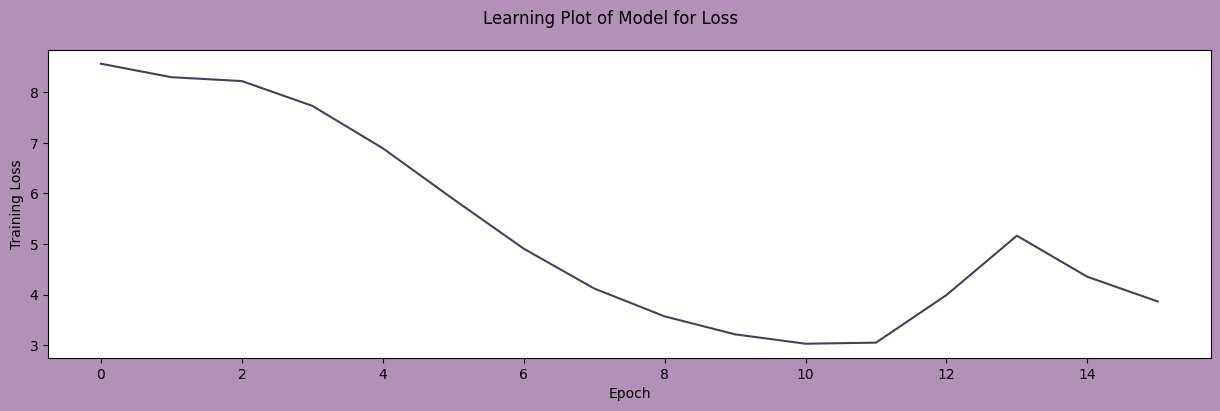

In [157]:
fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl = sns.lineplot(data=history_df["loss"], color="#444160")
pl.set(ylabel="Training Loss", xlabel="Epoch")
plt.show()

##9 Örnekleme Aşaması (NUCLEUS (TOP-p)) kullanıldı.

In [158]:
def sample_top_p(preds, temperature=0.8, top_p=0.9):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    probs = np.exp(preds)
    probs = probs / np.sum(probs)
    sorted_idx = np.argsort(probs)[::-1]
    cumulative = np.cumsum(probs[sorted_idx])
    keep = cumulative <= top_p
    idxs = sorted_idx[keep]
    if len(idxs) == 0:
        idxs = sorted_idx[:1]
    probs = probs[idxs] / probs[idxs].sum()
    return np.random.choice(idxs, p=probs)

def generate(seed_text,
             max_tokens=120,
             temperature=0.8,
             top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))
    return sp.decode(ids)


##9.Örnek üretimi **Proje GenAi kısmı sonu**
*### Resim üstü yazı olması için ve sonrasında arayüz için devam->17.04.2025*

In [159]:
print("---- ÖRNEK ÇIKIŞ ----")
print(generate("sevdik sevdalandık", max_tokens=120, temperature=0.5, top_p=0.95))
#Başlangıç parametrelerimiz çıktı kalitesi idare eder max_tokens=120, temperature=0.8, top_p=0.9))

---- ÖRNEK ÇIKIŞ ----
sevdik sevdalandık


#Proje geliştirmeleri
####Bundan sonraki aşamalar çıktı kalitesi için ve makinenin daha iyi çalışması için olacaktır. (Resim üstüne üretilen şarkı bu aşamada yapılmıştır.) Planlanan işler aşağıda belirtilmiştir. v1 Geliştirmeleri 20.01.2025 tarihinden önce yapılacaktır.

###Ekstra işler proje geliştirme

v1.1 (18.05.2025)
*   Drive üzerinde eğitilmiş model kaydı
*   Sözleri satır satır yazdırma,
*   Resim üzerine yazdırma

v2.0(After 22.05.2025)
*   Streamlit Arayüz tasarımı

V3.0 (Summer)
* yazdırılan sözlere uygun resim üretimi *textoimage*
    



##Model Kaydı

*Model kaydı deneme*

In [160]:
model.save('/content/drive/MyDrive/MRT_SMSK/20epoch.keras')

In [161]:
# ###Tekrar Kullanmak için Modeli Yükle

# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/MyDrive/MRT_SMSK/my_model.keras')


*Eğitim sırasında checkpoint kaydetme varmış denenecek*

In [162]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint'/content/drive/MyDrive/MRT_SMSK/my_model.keras', save_best_only=True, monitor='loss', mode='min')
# model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint])


##Şarkı sözlerini satır satır ayırmak

In [163]:
def teksatirdeneme(lyrics):
    for line in lyrics.split('\n'):
        print(line)

In [164]:
#yukarıda oluşturduğumuz generate'i çağıracağım
print(teksatirdeneme(generate("sevdamızın adı", max_tokens=120, temperature=0.5, top_p=0.95)))
#olmadı satırın bittiğini anlamıyor virgüllerden böleceğim.

sevdamızın adı aşkolsun Her gün yeni bir aşk Bir meçhul bir zamanda Bir orman bir şarkımış Sevgilim Bir akşam üstü bir vedada Ne sevdalı bir gün Kalbimin renklerinden Beni bir bahar akşamı Bir gün döndü izlenecek Karasışı Her şafakta Bir yanı güleç durur Bir yanı güleç durur Bir yanı evvel Aşık başlar Şu yanı başında Bir yanı evvel durur Bir yanı evvel bahar Bir yanı evvel Yan Bir yanı evveli yanı yanı başında Bir yanı güleç durur Bir yanı güleç bayram Bir yanı viran bayram Bir yanı viran bayram Bir yanı viran durur Bir yanı evvelinden Bir yanı evvel bayram Bir yanı viran bayram Bir yanı viran bayram Bir yanı viran durur
None


In [165]:
#virgülden bölme fonksiyonu
def virguldenbol(text):
    return text.replace(',', ',\n')


In [166]:
virguldenbol(generate("Allahım güç ver bana,seviyorum", max_tokens=120, temperature=0.5, top_p=0.9))
#bu niye çalışmadı ben de anlamaıdm--->yeni total fonksiyon tanımlanacak karışma ihtimaline karşı gener*

"Allahım güç ver bana,\nseviyorum sevmeyin Bugün beni ben dünyadan of,\n of turnam,\n gör beni beni Ben Yunus'da biçareyim,\n ben,\n Ben nerede büyüyorum sizinle"

In [167]:
def vırgul(text):
    """
    Metindeki her virgülden sonra alt satıra geçmek için '\\n' ekler.
    """
    return text.replace(',', ',\n')

def gener(seed_text, max_tokens=120, temperature=0.8, top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))

    generated_text = sp.decode(ids)
    formatted_text = vırgul(generated_text)
    return formatted_text

In [168]:
print((gener("sevda çiçekleri", max_tokens=120, temperature=0.5, top_p=0.9)))
#Satır ayırmanın virgüllere bağlandığında bazı çıktılarda çalışmadığını sonradan öğrendim resim sonrası tekrardan uğraşacağım

sevda çiçekleri düştüm ben Her güzele gönül veremem ben Açılmamıştım göçkarın ardından Rüzgar gelmiş şehirlere Bulup uzak tutunur Deniz yıldız olmuş Yalnız yağmur olsam da Aşk umutlarla büyüyen Hep yangın yeter özlem rıhtımında Biryerlerde Kaderde anlamlar vardı sende Bir akşam vakti vurdu sanki Bir şarkı bir aydınlıktı İnsanlığın yok Çocuklu bir ürkek


##Resim üstüne yazı ile şiir paylaşım konsepti

---



In [169]:
# 1⃣ Görsel dosyalarının yollarını değişkene ata
image_path  = "/content/drive/MyDrive/Python/acikfon.jpg"
output_path = "/content/drive/MyDrive/MRT_SMSK/cikti.jpg"

# 2⃣ Görsel üzerine yazı basan fonksiyon
def resim_ustune(image_path, lyrics, output_path):
    image = Image.open(image_path)
    draw  = ImageDraw.Draw(image)
    font = ImageFont.truetype("/content/drive/MyDrive/Python/times.ttf", 100)
    text_position = (120, 120)
    draw.multiline_text(text_position, lyrics, font=font, fill="black")
    image.save(output_path)
    image.show()

# 3⃣ Şarkı sözü üret
lyrics = gener(
    "Sensiz geçen günler",
    max_tokens=300,
    temperature=0.6,
    top_p=0.9
)
# 4⃣ Fonksiyonu çağır
resim_ustune(image_path, lyrics, output_path)


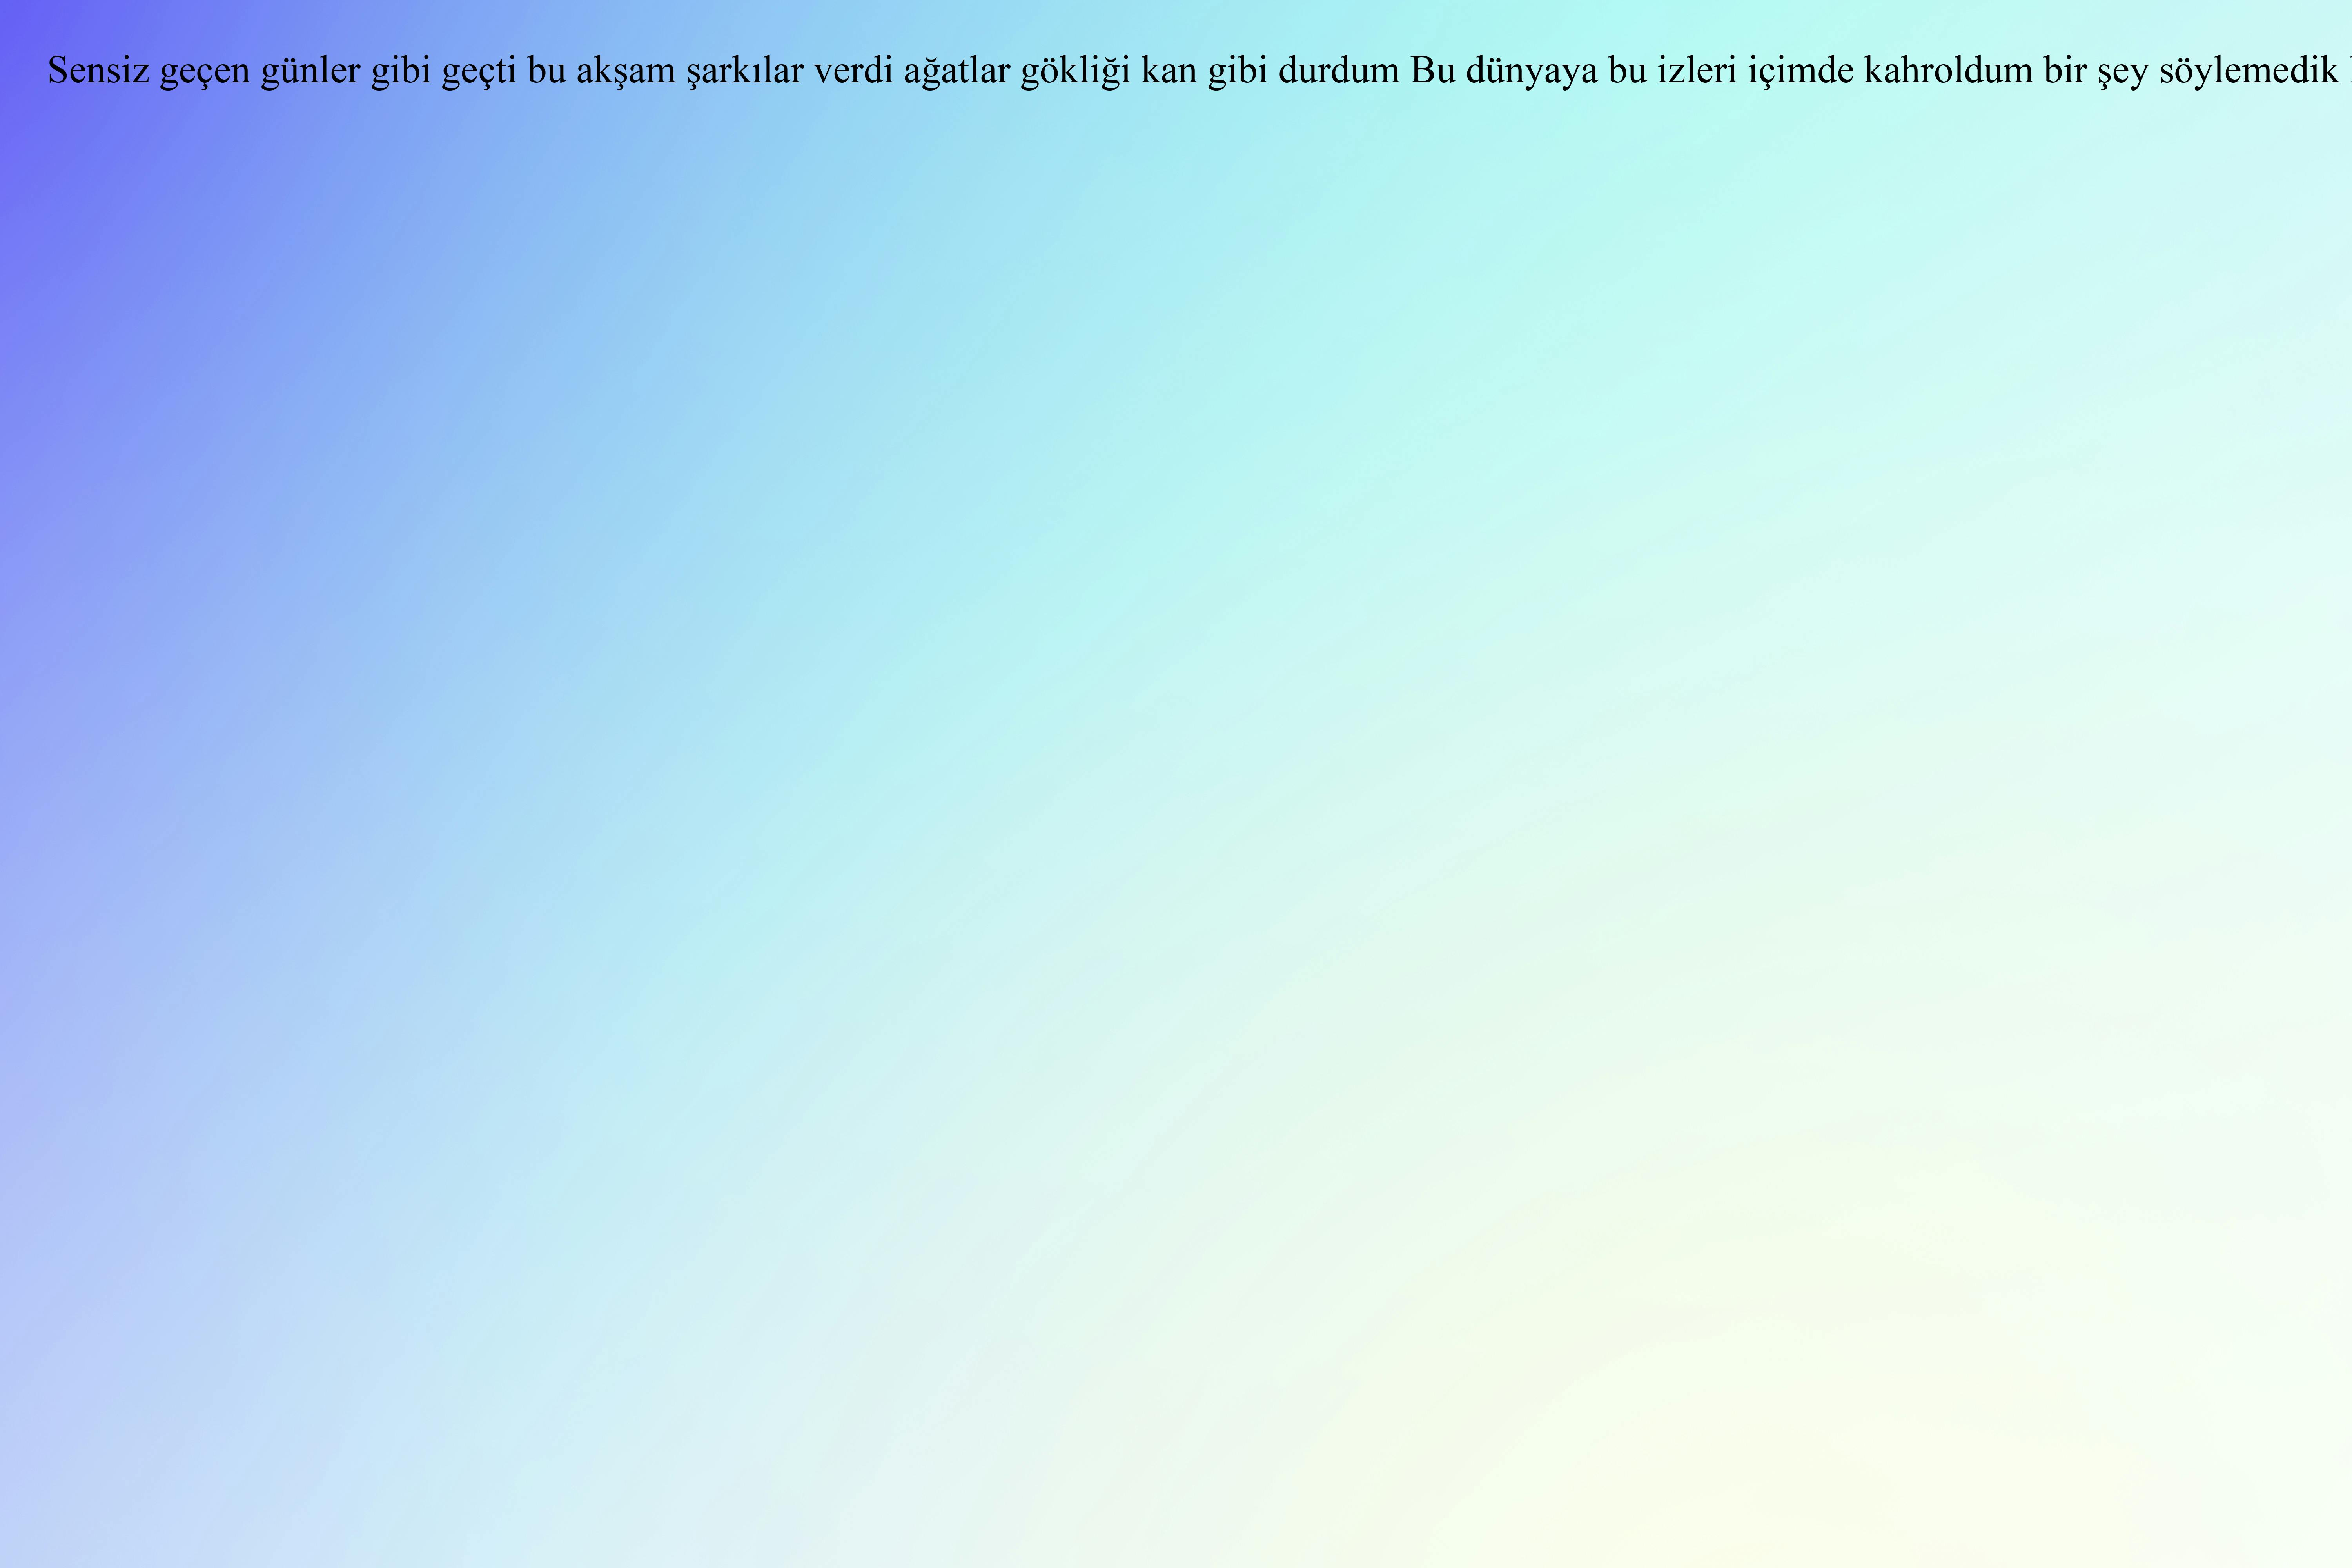

In [170]:
display(ColabImage(output_path))

##Satır Ayırma Kaliteli olacak
####virgülden ayırma bazı çıktılarda özellikle temp<0.5 ise çok
 bozuyor
####cümle başlangıçlarını büyük harflerle tespit edip böleceğimn
####fonksiyon generative-->gener-->yener

In [171]:
import re
def buyukharf(text):
    text = re.sub(r'(?<!\n)([A-ZÇĞİÖŞÜ])', r'\n\1', text)
    return text
def yener(seed_text, max_tokens=120, temperature=0.8, top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))

    generated_text = sp.decode(ids)
    formatted_text = buyukharf(generated_text)
    return formatted_text

In [182]:
print((yener("seni özledim", max_tokens=100, temperature=0.6, top_p=0.8)))

seni özledim bir yarım kalmış bir gün yok 
Herkes bir şey yok 
Gidiyorum senden bir gün daha önceleri nerelerdeydin bu dünyada bir kusur oldu bir gün bugün miyim ister ama bağımlı değildim 
Sen bir küçük sev eyvetini bilmiş gibi çok sevdiğimi 
Kolay değil zor geliyor 
Ona köşe sonunda gerek misin? 
Nasıl nasıl bir güvenmişim 
Bir de sen değerin ucunda bir varsın 
Cennetin içinde olsal bir sevgilim öyle bir yokmuşsun 
Evvel zaman düşün, zaman da geri dön, geri dön, sevme 
Vazgeçtim


In [180]:
# 1⃣ Görsel dosyalarının yollarını değişkene ata
image_path  = "/content/drive/MyDrive/Python/acikfon.jpg"
output_path = "/content/drive/MyDrive/MRT_SMSK/cikti.jpg"

# 2⃣ Görsel üzerine yazı basan fonksiyon
def resim_ustune(image_path, lyrics, output_path):
    image = Image.open(image_path)
    draw  = ImageDraw.Draw(image)
    font = ImageFont.truetype("/content/drive/MyDrive/Python/times.ttf", 100)
    text_position = (120, 120)
    draw.multiline_text(text_position, lyrics, font=font, fill="black")
    image.save(output_path)
    image.show()

# 3⃣ Şarkı sözü üret
lyrics = yener(
    "Sarı sarı bilezik",
    max_tokens=1000, #max token
    temperature=0.5, #saçmalama
    top_p=0.8 #toplam olasılığın kaçını havuza alayım
)
# 4⃣ Fonksiyonu çağır
resim_ustune(image_path, lyrics, output_path)

In [175]:
print(generate(lyrics))

Sarı sarı bileziği takarım kollarına dünyalar güzeli Kezban'ım bir de gelir bana belli Bir dağlara gel hiç ey Kaldın mı kul oldun mı Kaç yağları yazılar Kaleler ağır ağır ağır ağır ağır ağır ağır gelse de Duyan güneşlere Bu dünya bir nesiyiz söyle


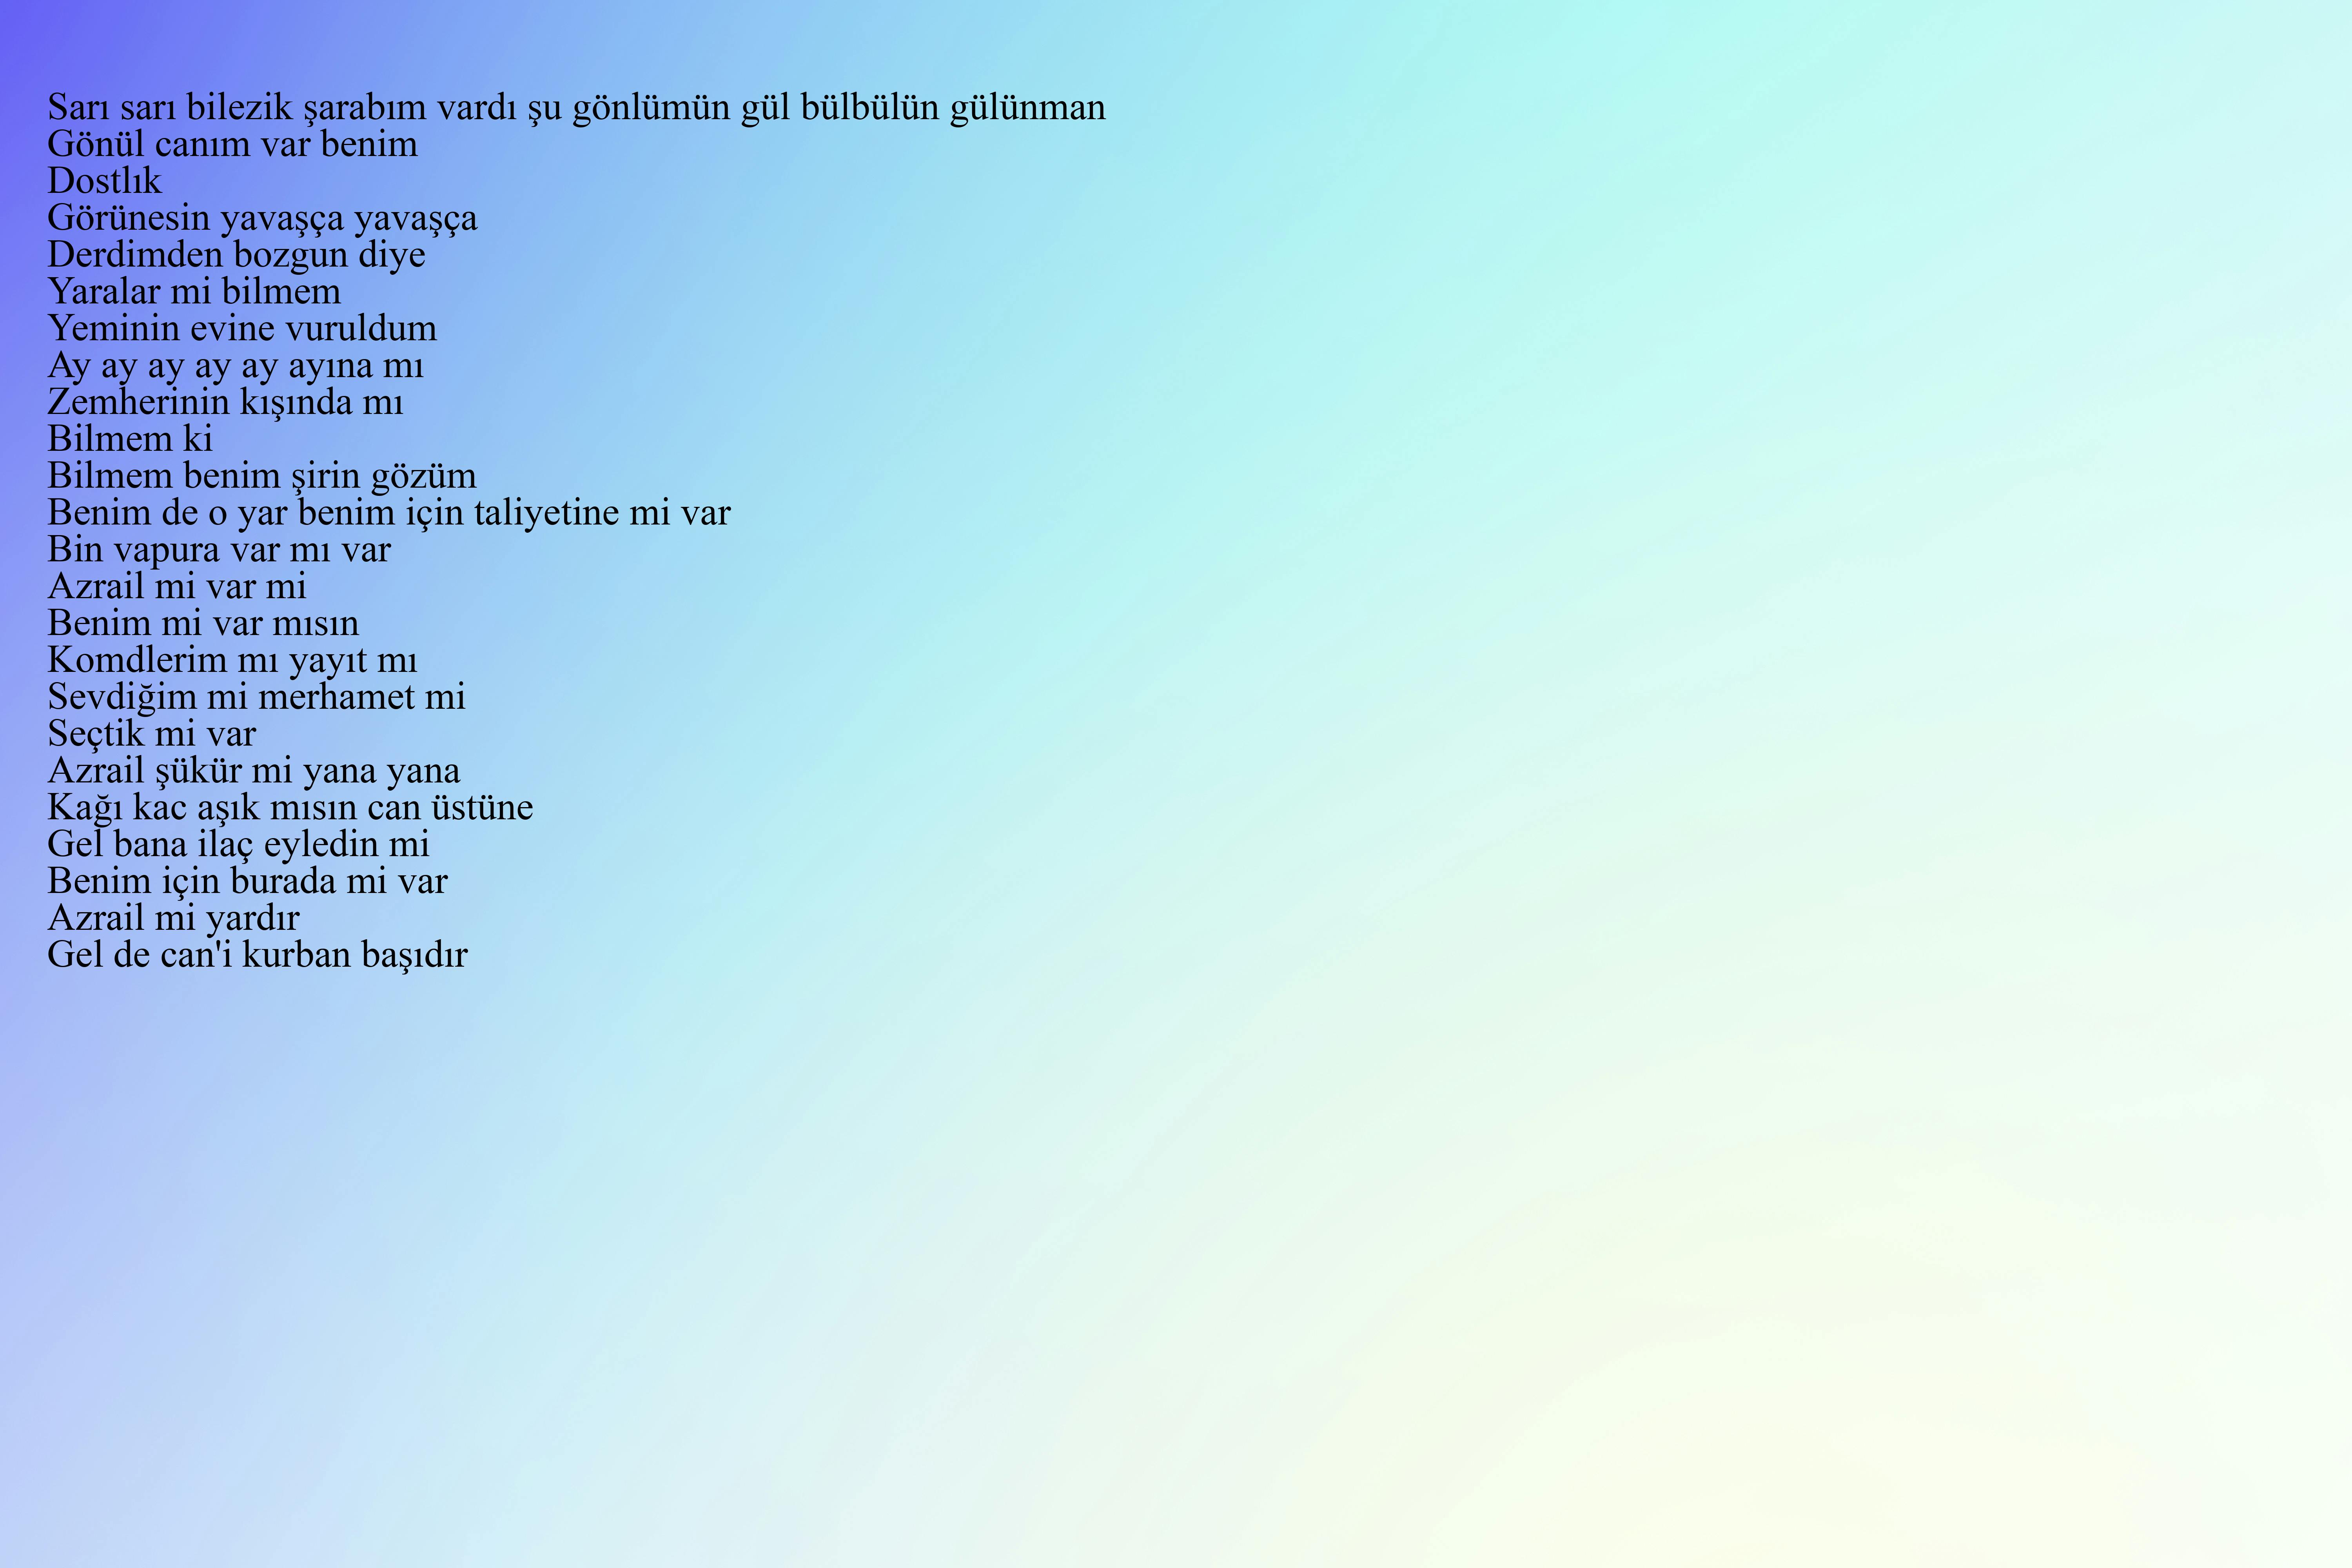

In [181]:
display(ColabImage(output_path))